In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode



In [3]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis       
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT, N_value=0.25):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = N_value
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('', flush=True)
    print('', flush=True)
    print(left_spacer + n * marker, flush=True)
    print(left_spacer + string, flush=True)
    print(left_spacer + n * marker, flush=True)
    print('', flush=True)
    print('', flush=True)
    
def decor_print(string):
    decor = 15*'-'
    print('', flush=True)
    print(decor + ' ' + string + ' ' + decor, flush=True)
    print('', flush=True)

    
def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps + 1):
            point_thetas = (i / num_steps * target_thetas)
            point_distributions = F.softmax(point_thetas, dim=-2)

            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1 for i in range(3)])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)

            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas)
        all_gradients.append(gradients)
    return torch.cat(all_salient_maps), theta_factor * torch.cat(all_gradients)

### Parse SatMut data

In [123]:
all_satmut_df = pd.read_csv('gs://syrgoth/data/saturation_mutagenesis/GRCh38_ALL.csv') #GRCh38_LDLR.csv
all_satmut_df = all_satmut_df[all_satmut_df.Alt != '-'].reset_index(drop=True)

In [124]:
element_cells = {'F9': 1, 'LDLR': 1, 'LDLR.2': 1, 'PKLR-24h': 0, 'PKLR-48h': 0, 'SORT1': 1, 'SORT1.2': 1,
                 'HNF4A':1, 'MYCrs6983267':1}

element = 'LDLR'
satmut_df = all_satmut_df[all_satmut_df.Element == element].reset_index(drop=True)

In [125]:
satmut_df

,Chromosome,Position,Ref,Alt,Tags,DNA,RNA,Value,P-Value,Element
0,19,11089231,A,C,27,1779,595,-0.13,0.45403,LDLR
1,19,11089231,A,G,49,3576,1837,0.00,0.99402,LDLR
2,19,11089231,A,T,232,21243,8589,0.00,0.95862,LDLR
3,19,11089232,G,A,611,44390,17899,0.05,0.16605,LDLR
4,19,11089232,G,C,128,6338,2409,-0.20,0.01546,LDLR
...,...,...,...,...,...,...,...,...,...,...
949,19,11089547,G,C,544,47963,18008,-0.04,0.28008,LDLR
950,19,11089547,G,T,205,22494,8618,0.02,0.70480,LDLR
951,19,11089548,C,A,126,14739,5215,-0.04,0.61217,LDLR
952,19,11089548,C,G,311,28703,11379,-0.04,0.44889,LDLR


In [126]:
coords = sorted(set(satmut_df.Position))

region_sequence = ''
region_values = []
for coord in coords:
    temp_df = satmut_df[satmut_df.Position == coord]
    site_ref = next(iter(set(temp_df.Ref)))
    region_sequence += site_ref
    #site_alts = sorted(set(constants.STANDARD_NT) - set(site_ref))
    site_alts = sorted(temp_df.Alt)
    site_values = torch.zeros(4)
    for site in site_alts:
        site_values[constants.STANDARD_NT.index(site)] = float(temp_df[temp_df.Alt == site].Value)
    region_values.append(site_values)
region_values = torch.stack(region_values, dim=1)

In [127]:
# matrix = region_values.view(4,-1)
# y_max = float(matrix.sum(dim=0).max())
# fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
#                   axisfontscale=0.6, heightscale=6)
# plt.show()

### Compare to contribution scores

In [128]:
step_size = 1
window_size = 200
batch_tensor = torch.stack([utils.dna2tensor(region_sequence[i:i+window_size]) for i in range(0, len(region_sequence)-window_size, step_size)])

In [129]:
eval_batch_size = 1040
cell_type = element_cells[element]

predictor = mpra_predictor(model=model, pred_idx=cell_type).cuda()

In [130]:
%%time
salient_maps, extended_contributions = isg_contributions(batch_tensor, predictor, eval_batch_size=eval_batch_size)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 11.9 s, sys: 138 ms, total: 12 s
Wall time: 12.1 s


In [131]:
num_channels = extended_contributions.shape[1]

num_windows = extended_contributions.shape[0]
window_size = extended_contributions.shape[-1]

if step_size != 1:
    last_window_start =  step_size * (num_windows - 1)
else:
    last_window_start =  step_size * num_windows
    
locus_length = last_window_start + window_size
full_window_contributions = torch.zeros(num_channels, locus_length)
for i in tqdm(range(0, last_window_start, step_size)):
    full_window_contributions[:,i:i+window_size] += extended_contributions[i//step_size,:,:].detach().cpu()

  0%|          | 0/118 [00:00<?, ?it/s]

In [132]:
max_num_windows = min(200, locus_length - window_size)
if locus_length > 2*window_size:
    divisors = torch.tensor(list(range(1, max_num_windows+1)) + (locus_length - 2*window_size)*[max_num_windows] + list(reversed(range(1, max_num_windows+1))))
else:
    divisors = torch.tensor(list(range(1, max_num_windows+1)) + (window_size - max_num_windows)*[max_num_windows] + list(reversed(range(1, max_num_windows+1))))

In [133]:
saturated_contributions = full_window_contributions.div(divisors)

In [134]:
# matrix = saturated_contributions.view(4,-1)
# y_max = float(matrix.max())
# fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
#                   axisfontscale=0.6, heightscale=2)
# plt.show()

In [135]:
# ref_tensor = utils.dna2tensor(region_sequence)
# matrix = (torch.ones_like(ref_tensor) - ref_tensor) * saturated_contributions.view(4,-1)
# y_max = float(matrix.sum(dim=0).max())
# fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
#                   axisfontscale=0.6, heightscale=6)
# plt.show()

In [136]:
# ref_tensor = utils.dna2tensor(region_sequence)
# matrix = ref_tensor * saturated_contributions.view(4,-1)
# y_max = float(matrix.sum(dim=0).max())
# fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
#                   axisfontscale=0.6, heightscale=4)
# plt.show()

### Model-simulated saturation mutagenesis

In [137]:
%%time
windows_as_strings = [region_sequence[i:i+window_size] for i in range(0, len(region_sequence)-window_size, step_size)]

predicted_saturations = []
for sequence_as_string in tqdm(windows_as_strings):
    combinations = []
    for idx in range(len(sequence_as_string)):
        four_combinations = torch.stack([utils.dna2tensor(sequence_as_string[:idx] + base + sequence_as_string[idx+1:]) for base in constants.STANDARD_NT])
        combinations.append(four_combinations)
    combinations = torch.stack(combinations).flatten(0,1)
    
    base_prediction = predictor(utils.dna2tensor(sequence_as_string).view(1,4,-1).cuda()).detach().cpu()
    sat_preds = predictor(combinations.cuda()).detach().cpu()
    
    predicted_saturations.append(sat_preds.unflatten(0, (200, 4)).T - base_prediction)
    
predicted_saturations = torch.stack(predicted_saturations)

  0%|          | 0/118 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 49.4 ms, total: 13.6 s
Wall time: 13.5 s


In [138]:
num_channels = predicted_saturations.shape[1]

num_windows = predicted_saturations.shape[0]
window_size = predicted_saturations.shape[-1]

if step_size != 1:
    last_window_start =  step_size * (num_windows - 1)
else:
    last_window_start =  step_size * num_windows
    
locus_length = last_window_start + window_size
full_window_contributions = torch.zeros(num_channels, locus_length)
for i in tqdm(range(0, last_window_start, step_size)):
    full_window_contributions[:,i:i+window_size] += predicted_saturations[i//step_size,:,:].detach().cpu()
    
max_num_windows = min(200, locus_length - window_size)
if locus_length > 2*window_size:
    divisors = torch.tensor(list(range(1, max_num_windows+1)) + (locus_length - 2*window_size)*[max_num_windows] + list(reversed(range(1, max_num_windows+1))))
else:
    divisors = torch.tensor(list(range(1, max_num_windows+1)) + (window_size - max_num_windows)*[max_num_windows] + list(reversed(range(1, max_num_windows+1))))
saturated_contributions = full_window_contributions.div(divisors)

  0%|          | 0/118 [00:00<?, ?it/s]

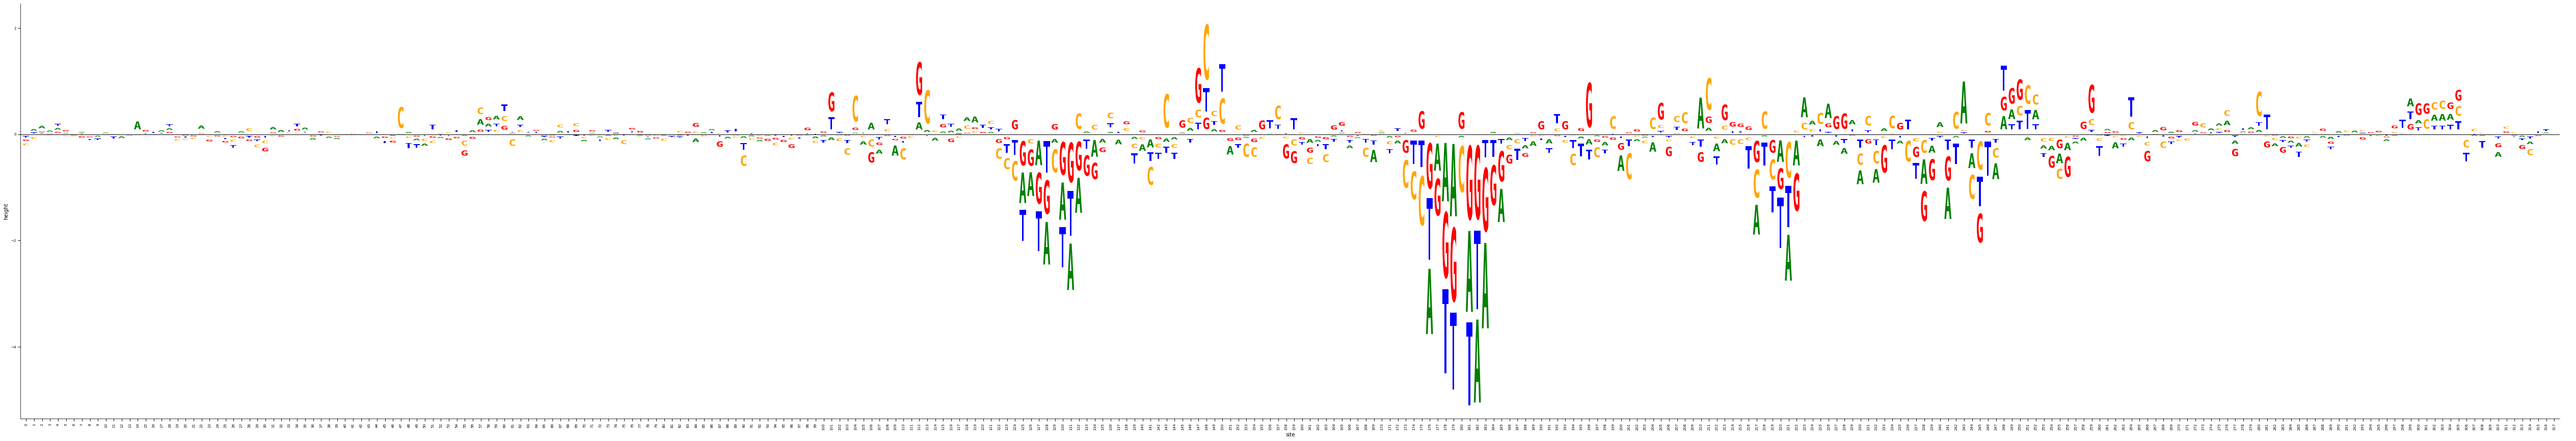

In [139]:
matrix = saturated_contributions.view(4,-1)
y_max = float(matrix.max())*2
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=6)
plt.show()